In [92]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import optimizers

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()
%matplotlib inline

In [53]:
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [2]:
mnist = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 18s 2us/step


In addition to splitting the data, we'll also normalize it between 0 - 1

In [144]:
(X_train_full, y_train_full), (X_test, y_test) = mnist
val_size = 10000
X_train, y_train = X_train_full[:-val_size]/255.0, y_train_full[:-val_size]
X_val, y_val = X_train_full[-val_size:]/255.0, y_train_full[-val_size:]

print(f'X_train shape {X_train.shape}')
print(f'X_val shape {X_val.shape}')
print(f'X_test shape {X_test.shape}')

num_classes = len(set(y_test))

X_train shape (50000, 28, 28)
X_val shape (10000, 28, 28)
X_test shape (10000, 28, 28)


In [145]:
# Scheduler for the learning rate.
# if init_lr = 1e-5 and the final learning rate is 10^6 this functions grows the lr
# by multiplying it by a constant factor at each iteration
def exp_scheduler(epochs, lr, n_iter=50):
    return lr * np.exp(np.log(10**6)/n_iter)

def lin_scheduler(epochs, lr):
    if epochs%10==0 and epochs!=0:
        return lr*10
    else:
        return lr

In [158]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
n_neurons = 100
activation = 'relu'
learning_rate = 1e-5
epochs = 100
batch_size = 32
es_patience = 10
optimizer = optimizers.SGD(lr=learning_rate)
callbacks = [keras.callbacks.TensorBoard(get_run_logdir()),
             keras.callbacks.EarlyStopping(patience=es_patience, restore_best_weights=True),
             keras.callbacks.LearningRateScheduler(lin_scheduler)]

inputs = Input(shape=X_train.shape[1:])
flatten = Flatten()(inputs)
hidden1 = Dense(n_neurons, activation=activation)(flatten)
hidden2 = Dense(n_neurons, activation=activation)(hidden1)
output = Dense(10, activation='softmax')(hidden2)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, 
          epochs=epochs, 
          validation_data=(X_val, y_val), 
          batch_size=batch_size,
          callbacks=callbacks)
history = model.history.history

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 62us/step

Epoch 49/100
50000/50000 [==============================] - 3s 58us/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.1050 - val_accuracy: 0.9732
Epoch 50/100
50000/50000 [==============================] - 3s 62us/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.1178 - val_accuracy: 0.9704
Epoch 51/100
50000/50000 [==============================] - 3s 65us/step - loss: 3.4504 - accuracy: 0.1087 - val_loss: 2.3052 - val_accuracy: 0.1030
Epoch 52/100
50000/50000 [==============================] - 3s 62us/step - loss: 2.3058 - accuracy: 0.1091 - val_loss: 2.3108 - val_accuracy: 0.1090
Epoch 53/100
50000/50000 [==============================] - 3s 60us/step - loss: 2.3083 - accuracy: 0.1051 - val_loss: 2.3210 - val_accuracy: 0.1009
Epoch 54/100
50000/50000 [==============================] - 3s 58us/step - loss: 2.3092 - accuracy: 0.1046 - val_loss: 2.3146 - val_accuracy: 0.0991
Epoch 55/100
50000/50000 [==============================] - 3s 53us/step - loss: 2.3110 - accuracy: 0.1075

In [159]:
def plot_model_loss(history):
    fig, ax = plt.subplots(figsize=(10,4))
    
    lr = history['lr']
    log_lr = np.log(lr)
    ax.plot(log_lr, history['loss'], 
            marker='.', linestyle='-', label='train_loss', alpha=0.7)
    ax.plot(log_lr, history['val_loss'],
            marker='.', linestyle='-', label='val_loss', alpha=0.7)
    ax.legend()
    ax.set_title('Learning Rate as a function of loss')
    ax.set_xlabel('learning rate')
    ax.set_ylabel('loss')
    
    fig.show()

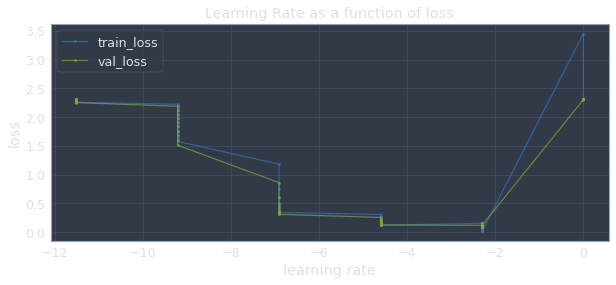

In [160]:
plot_model_loss(history)

Note how the loss shoots up after a certain point. we want the learning rate around that point. (also check the tensorboard visualizations for this)

In [163]:
max_loss = np.argmax(history['loss'])
max_loss_lr = history["lr"][max_loss]
print(f'LR with max loss{optimal_lr}')
history['lr'][max_loss-5:max_loss+5]

LR with max loss0.9999999403953552


[0.099999994,
 0.099999994,
 0.099999994,
 0.099999994,
 0.099999994,
 0.99999994,
 0.99999994,
 0.99999994,
 0.99999994,
 0.99999994]

Looks like $10^{-2}$ is a good learning rate

In [164]:
learning_rate = 1e-2
optimizer = optimizers.SGD(lr=learning_rate)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, 
          epochs=epochs, 
          validation_data=(X_val, y_val), 
          batch_size=batch_size,
          callbacks=callbacks)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 73us/step

In [165]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 23us/step


[13.160454574770789, 0.9779000282287598]

97.7% accuracy :D